In [29]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.special import j0, y0

In [2]:
def Z_transient(z, z0, wavenumber):
    """Compute the spatial structure function Z(z) with boundary condition Z(z0)=0."""
    # Compute Bessel function arguments
    arg = 2 * np.sqrt(wavenumber * z)
    arg0 = 2 * np.sqrt(wavenumber * z0)

    # Compute eigenfunction: Z(z) = J_0(arg) - (J_0(arg)/Y_0(arg)) * Y_0(arg)
    j0_z = j0(arg)
    y0_z = y0(arg)
    j0_z0 = j0(arg0)
    y0_z0 = y0(arg0)

    Z = j0_z - (j0_z0 / y0_z0) * y0_z
    # Normalize for better visualization
    Z_normalized = Z / np.max(np.abs(Z))
    return Z_normalized

In [19]:
# Parameters
dens  = 1.18                   # air density kg/m3
ustar = np.sqrt(1.2e-3 * 7**2)
qstar = 100.0 / ( dens * 2.5e6 * ustar )  # moisture scale kg/kg

vonk = 0.4                    # von Karman constant
k = ustar * vonk              # time-vertical separation constant m/s
timescale = 20 * 60           # decay timescale = 1/(wavenumber*k)
lambda_val = 1/timescale      # decay coefficient s^-1
wavenumber = 1/(timescale*k)  # vertical wavenumber m^-1

z0 = 1e-4                     # boundary position, roughness length, m

print(f"ustar = {ustar} m/s")
print(f"k = {k} m/s")
print(f"m = {wavenumber} 1/m")
print(f"height scale = {1/wavenumber} m")

ustar = 0.24248711305964282 m/s
k = 0.09699484522385714 m/s
m = 0.008591521862940859 1/m
height scale = 116.39381426862856 m


In [25]:
# Create z array
z_max = 220.0                # upper limit for plotting, m
z = np.linspace(z0, z_max, 1000)

# compute Z(z)
Z_normalized = Z_transient(z, z0, wavenumber)

imx  = np.argmax(Z_normalized)
print("max Z at z = ", z[imx], " m") # 2.9 m, very close to surface

max Z at z =  11.451546246246247  m


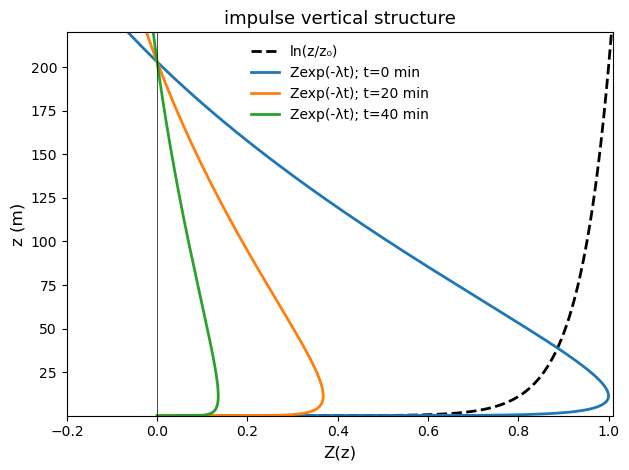

Parameters:
  λ = 0.0008333333333333334
  z₀ = 0.0001

Boundary condition check:
  Z(z₀) = 0.00e+00 ≈ 0 ✓


In [28]:
# Create figure vertical structure
fig, axes = plt.subplots(1, 1) #, figsize=(14, 10))
ax = axes

# Plot 1: Vertical structure Z(z) and decay over time
ax.plot(np.log(z/z0)/np.log(200/z0), z, linewidth=2, linestyle="--", color="k", label='ln(z/z₀)')
# ax.plot(Z_normalized, z, linewidth=2, label='Z(z)')
for tm in np.linspace(0, 2400, 3):
    ax.plot(Z_normalized*np.exp(-lambda_val*tm), z, linewidth=2, label='Zexp(-λt); t={:.0f} min'.format(tm/60))
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
# ax.axhline(y=z0, color='r', linestyle='--', alpha=0.5, label=f'z₀ = {z0}')
# ax.plot(z0, 0, 'ro', markersize=8, label='Boundary Z(z₀)=0')
# ax.plot(Z_normalized[imx], z[imx], 'b*')
ax.set_ylabel('z (m)', fontsize=12)
ax.set_xlabel('Z(z)', fontsize=12)
ax.set_title('impulse vertical structure', fontsize=13)
ax.set_xlim(-0.2, 1.01)
# ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
# ax.set_yscale('log')
ax.set_ylim(z0, z_max)

plt.tight_layout()
# plt.savefig('vert_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Parameters:")
print(f"  λ = {lambda_val}")
print(f"  z₀ = {z0}")
# print(f"  Bessel argument at z₀: 2√(λz₀) = {arg0:.4f}")
print(f"\nBoundary condition check:")
print(f"  Z(z₀) = {Z_normalized[0]:.2e} ≈ 0 ✓")

For eddy diffusion from a surface boundary,
$$
\frac{\partial q}{\partial t} = \frac{\partial}{\partial z}(K \frac{\partial q}{\partial z})
$$
with diffusivity $K=kz$, $k = \kappa u^*$, and boundary condition $q(z_0)$ at the roughness length $z_0;$ the steady solution is
$$
q(z) = q(z_0) + (q^*/\kappa)\ln(z/z_0).
$$

There are also time dependent solutions. The particular solution for an impulse that decays with timescale $\tau=\lambda^{-1}$ is
$$
Q(z,t) = A [J_0(\xi) + MY_0(\xi)] \exp(-\lambda t),
$$
where $A$ is a normalization constant, $J_0$ and $Y_0$ are Bessel functions of the first and second kind,
$M=J_0(2(\lambda z_0/k)^{1/2})/Y_0(2(\lambda z_0/k)^{1/2}),$ and
$\xi = 2(\lambda z/k)^{1/2}$. The vertical wavenumber is $m=\lambda/k$ and vertical scale height is $h=k\tau$ with separation constant $k=\kappa u^*$.
The general solution is 
$$
q(z) = q(z_0) + (q^*/\kappa)\ln(z/z_0) + Q(z,t).
$$

The time-dependent diffusion solution $Q(z,t)$ depends on the surface flux boundary condition like an entraining mixed layer. Yet in the similarity solution, the condition of the eddy diffusivity proportional to height replaces the entrainment boundary condition of the mixed layer.
For this diffusivity structure, the vertical structure is fixed with time for any constant time decay coefficient $\lambda$.


In [31]:
ds = xr.read("./release_data/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc")

AttributeError: module 'xarray' has no attribute 'read'

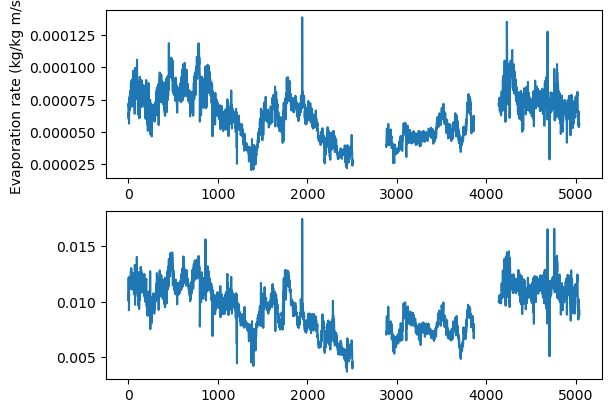

In [45]:
ds = xr.open_dataset("./release_data/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc")
fig,axes = plt.subplots(2,1) 

ax = axes[0]
ax.plot(ds["evap"]/(ds["rhoair"]*3600))
ax.set_ylabel("Evaporation rate (kg/kg m/s)")

wq = ds["evap"] / (ds["rhoair"]*3600) # mm/h to kg/kg m/s
Ws = wq / ( (ds["qskin"]-ds["qair"])*1e-3 )  # moisture flux / gradient kg/kg m/s
ax = axes[1]
ax.plot(Ws)